# Determine DEGs in Deseq2 Data

### 1. Import Required Packages
### 2. Import Deseq2 Data
### 3. Find Total Genes, DEGs, lncRNA DEGs, and Protein-Coding DEGs in Hepatocytes
### 4. K-Means Clustering of all Hepatocyte lncRNA DEGs
### 5. Plot k-means data


## <br> 1. Import Required Packages

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
from matplotlib_venn import venn2
from matplotlib_venn import venn3
import warnings

In [2]:
Deseq2_Directory = '../03a_TC_DEG_Analysis/Results/03d_MASTER_Deseq2_Concatonated/TC_Deseq2_Master_Wald_with_MGI.txt'

Deseq2_Master_TC = pd.read_csv(Deseq2_Directory, 
                            delimiter = '\t',
                            index_col=0)

Deseq2_Master_TC['Time'] = Deseq2_Master_TC['Time'].astype('category')


Deseq2_Master_TC = Deseq2_Master_TC.sort_values(by='Gene')
Deseq2_Master_TC.reset_index(drop=True, inplace=True)

Deseq2_Master_TC_lncRNA = Deseq2_Master_TC[(Deseq2_Master_TC['Type']== 'lncRNA') |
                                     (Deseq2_Master_TC['Type']== 'antisense') |
                                     (Deseq2_Master_TC['Type']== 'lincRNA') |
                                     (Deseq2_Master_TC['Type']== 'NR') |
                                     (Deseq2_Master_TC['Type']== 'lncOfInterest')]

In [3]:
Percentile_Directory = '../03a_TC_DEG_Analysis/Results/03c_Gene_Counts_and_Percentiles/Max_Count_Gene_Percentile_Per_Celltype.txt'

percentile_df_TC = pd.read_csv(Percentile_Directory, 
                            delimiter = '\t',
                            index_col=0)

## <br> 2. Import RDDR Deseq2 Data

In [9]:
Deseq2_Directory = '../01b_RDDR_DEG_Analysis/Results/03d_MASTER_Deseq2_Concatonated/RDDR_Deseq2_Master_Wald_with_MGI.txt'

Deseq2_Master = pd.read_csv(Deseq2_Directory, 
                            delimiter = '\t',
                            index_col=0)

Deseq2_Master['Dose'] = Deseq2_Master['Dose'].astype('category')


Deseq2_Master = Deseq2_Master.sort_values(by='Gene')
Deseq2_Master.reset_index(drop=True, inplace=True)

Deseq2_Master_lncRNA = Deseq2_Master[(Deseq2_Master['Type']== 'lncRNA') |
                                     (Deseq2_Master['Type']== 'antisense') |
                                     (Deseq2_Master['Type']== 'lincRNA') |
                                     (Deseq2_Master['Type']== 'NR') |
                                     (Deseq2_Master['Type']== 'lncOfInterest')]

In [10]:
Percentile_Directory = '../01b_RDDR_DEG_Analysis/Results/03c_Gene_Counts_and_Percentiles/Max_Count_Gene_Percentile_Per_Celltype.txt'

percentile_df = pd.read_csv(Percentile_Directory, 
                            delimiter = '\t',
                            index_col=0)

## 3. Process Dose Response Data

In [11]:
#define Log2FC threshold and padj-value
FC = 1.5
padj = 0.05

In [12]:
Deseq2_PC_Hep = Deseq2_Master_lncRNA[Deseq2_Master_lncRNA['Celltype'] == 'Centrilobular Hepatocytes']
Deseq2_PP_Hep = Deseq2_Master_lncRNA[Deseq2_Master_lncRNA['Celltype'] == 'Periportal Hepatocytes']

percentile_PC_Hep = percentile_df[['Centrilobular Hepatocytes']]
percentile_PP_Hep = percentile_df[['Periportal Hepatocytes']]

percentile_PC_Hep.reset_index(inplace=True)
percentile_PP_Hep.reset_index(inplace=True)

# Perform the merge based on the 'Gene' column from Deseq2_PC_Hep and the index from percentile_df
PC_Hep_Merged = pd.merge(Deseq2_PC_Hep, percentile_PC_Hep, left_on='Gene', right_on='index')
PC_Hep_Merged.drop(columns=['index'], inplace=True)

PP_Hep_Merged = pd.merge(Deseq2_PP_Hep, percentile_PP_Hep, left_on='Gene', right_on='index')
PP_Hep_Merged.drop(columns=['index'], inplace=True)

# Rename the 'X Hepatocytes' column to 'Abundance Percentile'
PC_Hep_Merged.rename(columns={'Centrilobular Hepatocytes': 'Abundance Percentile'}, inplace=True)
PP_Hep_Merged.rename(columns={'Periportal Hepatocytes': 'Abundance Percentile'}, inplace=True)

PC_Hep_Merged_Short = PC_Hep_Merged[['Gene','Celltype','Dose','Fold-Change','log2FoldChange','padj','Abundance Percentile']].drop_duplicates(keep='first')
PP_Hep_Merged_Short = PP_Hep_Merged[['Gene','Celltype','Dose','Fold-Change','log2FoldChange','padj','Abundance Percentile']].drop_duplicates(keep='first')


PC_Hep_DEGs = PC_Hep_Merged_Short[((PC_Hep_Merged_Short['Fold-Change'] >= FC) | 
                             (PC_Hep_Merged_Short['Fold-Change'] <= 1/FC)) &
                             (PC_Hep_Merged_Short['padj'] <= padj)
                            ]

PP_Hep_DEGs = PP_Hep_Merged_Short[((PP_Hep_Merged_Short['Fold-Change'] >= FC) | 
                             (PP_Hep_Merged_Short['Fold-Change'] <= 1/FC)) &
                             (PP_Hep_Merged_Short['padj'] <= padj)
                           ]

#extract only the Abundace Percentiles for histograms
PC_Hep_DEGs_List = PC_Hep_DEGs[['Gene', 'Abundance Percentile']].drop_duplicates(keep='first')
PP_Hep_DEGs_List = PP_Hep_DEGs[['Gene', 'Abundance Percentile']].drop_duplicates(keep='first')

PC_Hep_DEGs_30 = PC_Hep_DEGs[PC_Hep_DEGs['Dose'] == 30.00]
PP_Hep_DEGs_30 = PP_Hep_DEGs[PP_Hep_DEGs['Dose'] == 30.00]


## 4A. Determine overlapping DEGs in the RDDR from any Dose

In [15]:
# Find common DEGs from any Dose
common_genes = pd.merge(PP_Hep_DEGs, PC_Hep_DEGs, on='Gene', suffixes=('_PP', '_PC')).drop_duplicates(keep='first')

# Find genes only in PP
only_PP = PP_Hep_DEGs[~PP_Hep_DEGs['Gene'].isin(PC_Hep_DEGs['Gene'])].drop_duplicates(subset=['Gene'], keep='first')

# Find genes only in PC
only_PC = PC_Hep_DEGs[~PC_Hep_DEGs['Gene'].isin(PP_Hep_DEGs['Gene'])].drop_duplicates(subset=['Gene'], keep='first')


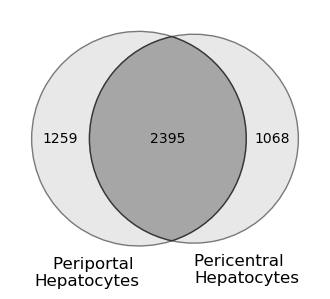

In [16]:
# Extract the sets
set_PP = set(only_PP['Gene'])
set_PC = set(only_PC['Gene'])
set_common = set(common_genes['Gene'])

# Calculate the sizes for the Venn diagram
only_PP_size = len(set_PP)
only_PC_size = len(set_PC)
common_size = len(set_common)

# Create the Venn diagram
plt.figure(figsize=(4,4))
venn = venn2(subsets=(only_PP_size, only_PC_size, common_size), 
             set_labels=('Periportal \nHepatocytes', 'Pericentral \nHepatocytes'))

# Customize the colors
venn.get_patch_by_id('10').set_color('#d3d3d3')  # Only PP
venn.get_patch_by_id('01').set_color('#d3d3d3')  # Only PC
venn.get_patch_by_id('11').set_color('#4f4f4f')  # Common

# Set transparency (alpha)
venn.get_patch_by_id('10').set_alpha(0.5)
venn.get_patch_by_id('01').set_alpha(0.5)
venn.get_patch_by_id('11').set_alpha(0.5)

# Add black border
venn.get_patch_by_id('10').set_edgecolor('black')
venn.get_patch_by_id('01').set_edgecolor('black')
venn.get_patch_by_id('11').set_edgecolor('black')

# Set the edge width
venn.get_patch_by_id('10').set_linewidth(1.0)
venn.get_patch_by_id('01').set_linewidth(1.0)
venn.get_patch_by_id('11').set_linewidth(1.0)


# Display the plot
#plt.title("Venn Diagram of DEGs in PP and PC")

plt.savefig('./Figures/Venn_Diagram_DEGs_PP_PC.pdf', format='pdf')

plt.show()

## 4B. Determine overlapping DEGs in the RDDR from only the 30 ug/kg dose

In [17]:
# Find common DEGs from any time-point
common_genes_30 = pd.merge(PP_Hep_DEGs_30, PC_Hep_DEGs_30, on='Gene', suffixes=('_PP', '_PC')).drop_duplicates(keep='first')

# Find genes only in PP
only_PP_30 = PP_Hep_DEGs_30[~PP_Hep_DEGs_30['Gene'].isin(PC_Hep_DEGs_30['Gene'])].drop_duplicates(subset=['Gene'], keep='first')

# Find genes only in PC
only_PC_30 = PC_Hep_DEGs_30[~PC_Hep_DEGs_30['Gene'].isin(PP_Hep_DEGs_30['Gene'])].drop_duplicates(subset=['Gene'], keep='first')


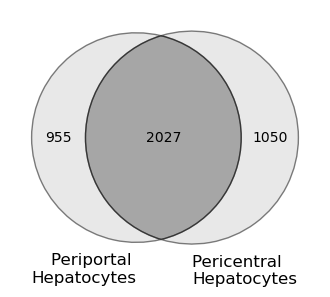

In [18]:
# Extract the sets
set_PP = set(only_PP_30['Gene'])
set_PC = set(only_PC_30['Gene'])
set_common = set(common_genes_30['Gene'])

# Calculate the sizes for the Venn diagram
only_PP_size = len(set_PP)
only_PC_size = len(set_PC)
common_size = len(set_common)

# Create the Venn diagram
plt.figure(figsize=(4,4))
venn = venn2(subsets=(only_PP_size, only_PC_size, common_size), 
             set_labels=('Periportal \nHepatocytes', 'Pericentral \nHepatocytes'))

# Customize the colors
venn.get_patch_by_id('10').set_color('#d3d3d3')  # Only PP
venn.get_patch_by_id('01').set_color('#d3d3d3')  # Only PC
venn.get_patch_by_id('11').set_color('#4f4f4f')  # Common

# Set transparency (alpha)
venn.get_patch_by_id('10').set_alpha(0.5)
venn.get_patch_by_id('01').set_alpha(0.5)
venn.get_patch_by_id('11').set_alpha(0.5)

# Add black border
venn.get_patch_by_id('10').set_edgecolor('black')
venn.get_patch_by_id('01').set_edgecolor('black')
venn.get_patch_by_id('11').set_edgecolor('black')

# Set the edge width
venn.get_patch_by_id('10').set_linewidth(1.0)
venn.get_patch_by_id('01').set_linewidth(1.0)
venn.get_patch_by_id('11').set_linewidth(1.0)


# Display the plot
#plt.title("Venn Diagram of DEGs in PP and PC")

plt.savefig('./Figures/Venn_Diagram_DEGs_PP_PC_30ug_kg.pdf', format='pdf')

plt.show()